In [1]:
!pip install tensorflow

In [2]:
import numpy as np

#get dataset
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt 

#load dataset
(trainX,trainy),(testX,testy) = load_data() #total 10 classes

2022-11-22 21:37:16.600967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 21:37:16.778000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 21:37:16.778035: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 21:37:17.589361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

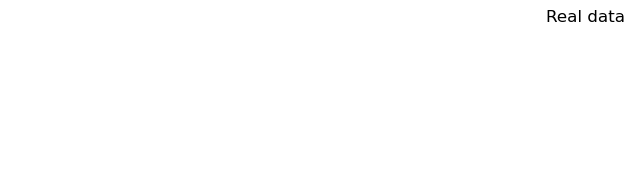

In [3]:
#show images
fig,axes=plt.subplots(1,6,figsize=(8,2))
plt.title('Real data',fontdict={'horizontalalignment': 'center'},loc='center')
#fig.suptitle('Real data')
for ax in axes.flatten():
    idx=np.random.randint(len(trainX))
    ax.set_axis_off()
    #ax.imshow(trainX[idx])
    
fig.savefig('gan_plots/fig.png')

In [4]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.utils.vis_utils import plot_model
import numpy as np

In [5]:
#defining discriminator model
def define_descriminator(in_shape=(32,32,3)):
    model=Sequential()
    #normal
    model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(0.2))
    #downsampling
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(0.2))
    #downsampling
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(0.2))
    #downsampling
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(0.2))
    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
              
    #compile model
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5), metrics=['accuracy'])
    return model

In [6]:
#define model
model=define_descriminator()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

2022-11-22 21:37:19.803126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 21:37:19.803186: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 21:37:19.803215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ae61cf1764fd): /proc/driver/nvidia/version does not exist
2022-11-22 21:37:19.803610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/a

In [7]:
#load and scale real data
def load_real_samples():
    (trainX,_),(_,_)=load_data()
    X=trainX.astype('float32')
    #scale from (0,255) to (-1,1) for better performance in gans
    X=(X-127.5)/127.5
    return X

In [8]:
#select real samples
def generate_real_samples(dataset,n_samples):
    #choose random samples
    ix=np.random.randint(0,len(dataset),n_samples)
    X=dataset[ix]
    #generate real class label i.e 1
    y=np.ones((n_samples,1))
    return X,y

In [9]:
#generate fake samples with label
def generate_fake_samples(n_samples):
    #generate uniform random numbers in range (0,1)
    X=np.random.rand(32*32*3*n_samples)
    X= -1 + X*2
    X=X.reshape((n_samples,32,32,3))
    #generate fake class labels i.e 0
    y=np.zeros((n_samples,1))
    return X,y

In [10]:
#train discriminator model temporarily
def train_discriminator(model,dataset,n_iter=20,n_batch=128):
    half_batch=int(n_batch/2)
    
    #loop for no. of epochs (n_iters)
    for i in range(n_iter):
        #train on real samples
        X_real,y_real=generate_real_samples(dataset,half_batch)
        _,real_accuracy=model.train_on_batch(X_real,y_real)
        #train on fake samples
        X_fake,y_fake=generate_fake_samples(half_batch)
        _,fake_accuracy=model.train_on_batch(X_fake,y_fake)    
        
        print(f'Epoch:{i} Accuracy : real data = {real_accuracy*100}% , fake data = {fake_accuracy*100}%')

In [11]:
#example training discriminator modek
model=define_descriminator()
dataset=load_real_samples()
train_discriminator(model,dataset)

Epoch:0 Accuracy : real data = 35.9375% , fake data = 3.125%
Epoch:1 Accuracy : real data = 90.625% , fake data = 10.9375%
Epoch:2 Accuracy : real data = 92.1875% , fake data = 39.0625%
Epoch:3 Accuracy : real data = 95.3125% , fake data = 73.4375%
Epoch:4 Accuracy : real data = 90.625% , fake data = 100.0%
Epoch:5 Accuracy : real data = 90.625% , fake data = 100.0%
Epoch:6 Accuracy : real data = 75.0% , fake data = 100.0%
Epoch:7 Accuracy : real data = 95.3125% , fake data = 100.0%
Epoch:8 Accuracy : real data = 84.375% , fake data = 100.0%
Epoch:9 Accuracy : real data = 79.6875% , fake data = 100.0%
Epoch:10 Accuracy : real data = 93.75% , fake data = 100.0%
Epoch:11 Accuracy : real data = 96.875% , fake data = 100.0%
Epoch:12 Accuracy : real data = 98.4375% , fake data = 100.0%
Epoch:13 Accuracy : real data = 98.4375% , fake data = 100.0%
Epoch:14 Accuracy : real data = 98.4375% , fake data = 100.0%
Epoch:15 Accuracy : real data = 96.875% , fake data = 100.0%
Epoch:16 Accuracy : rea

In [12]:
#define generator model
def define_generator(latent_dim):
    model=Sequential()
    #foundation for 4*4 image
    n_nodes=256*4*4
    model.add(Dense(n_nodes,input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    #upscale to 8*8
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upscale to 16*16
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upscale to 32*32
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #output layer
    model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
    return model

In [13]:
#define latent space
latent_dim=100
#define generator model
model=define_generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [14]:
#generate points in latent space as input to generator
def generate_latent_points(latent_dim,n_samples):
    X_input=np.random.randn(latent_dim*n_samples)
    X_input=X_input.reshape(n_samples,latent_dim)
    return X_input

In [15]:
#use generator to generate fake examples with class label
def generate_fake_samples(g_model,latent_dim,n_samples):
    #generate points in latent space
    X_input=generate_latent_points(latent_dim,n_samples)
    #predict outputs
    X=g_model.predict(X_input)
    #create fale class labels i.e 0
    y=np.zeros((n_samples,1))
    return X,y

In [16]:
#define gan i.e combined discriminator and generator
def gan(g_model,d_model):
    #freeze discriminator model weights
    d_model.trainable=False
    
    model=Sequential()
    model.add(g_model)
    model.add(d_model)
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0002,beta_1=0.5))
    return model

In [17]:
#size of latent dim
latent_dim=100
#generate gan model
d_model=define_descriminator()
g_model=define_generator(latent_dim)
gan_model=gan(g_model,d_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [18]:
#train generator and discriminator
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128):
    batch_per_epoch=int(len(dataset)/n_batch)
    half_batch=int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            #train discriminator on real samples
            X_real,y_real=generate_real_samples(dataset,half_batch)
            d_loss1,_=d_model.train_on_batch(X_real,y_real)
            #train discriminator on fake samples
            X_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
            d_loss2,_=d_model.train_on_batch(X_fake,y_fake)
            #generate latent dims for generator
            X_gan=generate_latent_points(latent_dim,n_batch)
            #create inverted labels for fake samples
            y_gan=np.ones((n_batch,1))
            #update generator via discriminators error
            g_loss=gan_model.train_on_batch(X_gan,y_gan)
            
            #summarize data            
            if (j+1)%30==0:
                print(f'epoch:{i}/{n_epochs} ,batch:{j}/{batch_per_epoch} ,disc_loss(real):{d_loss1} ,disc_loss(fake):{d_loss2} ,gan_loss:{g_loss}')
            
        if (i+1)%10==0:
            #evaluate discriminator
            summarize_performance(i+1,g_model,d_model,dataset,latent_dim)
        
        #summarize data
        #print(f'epoch:{i}/{n_epochs} ,disc_loss(real):{d_loss1} ,disc_loss(fake):{d_loss2} ,gan_loss:{g_loss}')

In [19]:
#evaluate discriminator
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):
    X_real,y_real=generate_real_samples(dataset,half_batch)
    _,acc_real=d_model.evaluate(X_real,y_real)
    #train discriminator on fake samples
    X_fake,y_fake=generate_fake_samples(g_model,latent_dim,half_batch)
    _,acc_fake=d_model.evaluate(X_fake,y_fake)
    
    print(f'Accuracy: real_data:{acc_real*100} ,fake_data:{acc_fake*100}')
    save_plot(X_fake,epoch)
    g_model.save('generator_model.h5',overwrite=True)

In [20]:
def save_plt(examples,epoch,n=6):
    #scale from (-1,1) to (0,1)
    examples=(examples+1)/2.0
    #show images
    fig,axes=plt.subplots(1,n,figsize=(8,2))
    plt.title(f'generated_img (epoch={epoch})',fontdict={'horizontalalignment': 'center'},loc='center')
    #fig.suptitle('Real data')
    for ax in axes.flatten():
        idx=np.random.randint(len(examples))
        ax.set_axis_off()
        ax.imshow(examples[idx])
        
    fig.savefig(f'gan_plots/generated_img_epoch{epoch}.png')

In [ ]:
dataset=load_real_samples()
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128)

In [29]:
g_model.save('generator_model.h5',overwrite=True)

2

In [ ]:
from keras.models import load_model

#Generate new images
model=load_model('generator_model.h5')
latent_points=generate_latent_points(100,100)
X=model.predict(latent_points)
#Scale from (-1,1) to (0,1)
X=(X+1)/2

fig,axes=plt.subplots(1,n,figsize=(8,2))
fig.suptitle('Real data')
for ax in axes.flatten():
    idx=np.random.randint(len(X))
    ax.set_axis_off()
    ax.imshow(X[idx])